In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
data = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')

# Assume last column is the label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Class-balanced 90/10 split using StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# Pipeline with scaling, SVD, and LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse
    ('svd', TruncatedSVD()),                      # n_components tuned in grid
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])

# Grid search parameters
param_grid = {
    'svd__n_components': [100, 300, 500],
    'clf__C': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:")
print(grid.best_params_)

# Evaluate on test set
y_pred = grid.predict(X_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:
{'clf__C': 0.1, 'svd__n_components': 500}

Classification Report (Test Set):
              precision    recall  f1-score   support

     Agresti       1.00      1.00      1.00         2
   Ashbacher       0.00      0.00      0.00         1
       Auken       0.00      0.00      0.00         1
 Blankenship       1.00      1.00      1.00         2
       Brody       1.00      0.50      0.67         2
       Brown       0.00      0.00      0.00         1
    Bukowsky       1.00      0.50      0.67         2
         CFH       1.00      1.00      1.00         1
   Calvinnme       1.00      0.50      0.67         2
     Chachra       0.50      1.00      0.67         2
    Chandler       0.00      0.00      0.00         2
       Chell       0.50      1.00      0.67         2
    Cholette       1.00      0.50      0.67         2
      Comdet       0.50      1.00      0.67         2
        Corn       0.33      0.50 

D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# Load dataset
data = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

from sklearn.feature_selection import SelectKBest, chi2

pipeline = Pipeline([
    ('selector', SelectKBest(chi2, k=5000)),  # try k=2000–8000
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD()),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])


# Define parameter grid
param_grid = {
    'svd__n_components': [300, 500, 700],
    'clf__C': [0.01, 0.1, 1]
}

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X, y)

# Results
print("Best Accuracy:", grid.best_score_)
print("Best Parameters:", grid.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Accuracy: 0.728
Best Parameters: {'clf__C': 0.01, 'svd__n_components': 700}


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# ---------- LOAD DATA ---------- #

train_data = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
test_data = pd.read_csv('all_datasets/amazon_review_ID.shuf.tes.csv')

# Separate X and y
X_train_raw = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test_raw = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# ---------- FEATURE ENGINEERING ---------- #

def add_engineered_features(X_raw, y_labels=None):
    # 1. Total word count
    total_wc = X_raw.sum(axis=1).reshape(-1, 1)

    # 2. Average word frequency
    nonzero_counts = (X_raw > 0).sum(axis=1)
    nonzero_counts_safe = np.where(nonzero_counts == 0, 1, nonzero_counts)
    avg_word_freq = (X_raw.sum(axis=1) / nonzero_counts_safe).reshape(-1, 1)

    # 3. Author review count (only available for training set)
    if y_labels is not None:
        y_series = pd.Series(y_labels)
        review_counts = y_series.value_counts()
        author_review_count = y_series.map(review_counts).values.reshape(-1, 1)
    else:
        # For test set, we'll simulate by giving average count across train set
        author_review_count = np.full((X_raw.shape[0], 1), fill_value=15)  # mean ~15

    return np.hstack([X_raw, total_wc, avg_word_freq, author_review_count])

X_train = add_engineered_features(X_train_raw, y_train)
X_test = add_engineered_features(X_test_raw)

# ---------- BUILD PIPELINE ---------- #

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD()),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])

# ---------- GRID SEARCH ---------- #

param_grid = {
    'svd__n_components': [300, 500, 700],
    'clf__C': [0.01, 0.1, 1]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Fitting model on full training set...")
grid.fit(X_train, y_train)

# ---------- EVALUATE ON TEST SET ---------- #

print("\n✅ Best Parameters:", grid.best_params_)
y_pred = grid.predict(X_test)

print("\n📊 Test Set Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n🏁 Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# ---------- SAVE PREDICTIONS TO CSV WITH Review_ID ---------- #

# Load Review_IDs from test set (assumes it's the first column)
review_ids = test_data.iloc[:, 0]

output_df = pd.DataFrame({
    'Review_ID': review_ids,
    'predicted_author': y_pred
})

output_df.to_csv('local_reviews_submission_v15.csv', index=False)
print("\n📁 Predictions with Review_ID saved to: local_reviews_submission_v15.csv")


Fitting model on full training set...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

✅ Best Parameters: {'clf__C': 0.01, 'svd__n_components': 700}


ValueError: X has 10003 features, but StandardScaler is expecting 10004 features as input.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer

# -------------------------------
# 1. Load and prepare the data
# -------------------------------
train_df = pd.read_csv('all_datasets/amazon_review_ID.shuf.lrn.csv')
test_df = pd.read_csv('all_datasets/amazon_review_ID.shuf.tes.csv')

X_raw = train_df.drop(columns=["ID", "Class"])
y_raw = train_df["Class"]
X_test_raw = test_df.drop(columns=["ID"])
test_ids = test_df["ID"]

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# -------------------------------
# 2. TF-IDF Transformation
# -------------------------------
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

# -------------------------------
# 3. SelectKBest before weighting (must be non-negative input)
# -------------------------------
selector = SelectKBest(chi2, k=5000)
X_selected = selector.fit_transform(X_tfidf, y_encoded)
X_test_selected = selector.transform(X_test_tfidf)

# -------------------------------
# 4. Log-Count Ratio Weighting
# -------------------------------
alpha = 1
X_counts = X_raw.values
log_count_ratios = np.zeros(X_counts.shape[1])
n_classes = len(np.unique(y_encoded))

for i in range(n_classes):
    p = X_counts[y_encoded == i].sum(axis=0) + alpha
    q = X_counts[y_encoded != i].sum(axis=0) + alpha
    log_count_ratios += np.log(p / p.sum()) - np.log(q / q.sum())
log_count_ratios /= n_classes

# Apply weights ONLY on selected features
log_count_ratios_selected = log_count_ratios[selector.get_support()]
X_selected = X_selected.multiply(log_count_ratios_selected)
X_test_selected = X_test_selected.multiply(log_count_ratios_selected)

# -------------------------------
# 5. Build the Pipeline
# -------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('svd', TruncatedSVD()),
    ('clf', LinearSVC(class_weight='balanced', max_iter=5000))
])

# -------------------------------
# 6. Grid Search with Stratified CV
# -------------------------------
param_grid = {
    'svd__n_components': [800],
    'clf__C': [0.01]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_selected, y_encoded)

# -------------------------------
# 7. Print Best Results
# -------------------------------
print("Best Accuracy:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# -------------------------------
# 8. Predict on Test Set
# -------------------------------
best_model = grid.best_estimator_
test_preds = best_model.predict(X_test_selected)
test_labels = label_encoder.inverse_transform(test_preds)

# -------------------------------
# 9. Save Kaggle Submission File
# -------------------------------
submission = pd.DataFrame({
    "ID": test_ids,
    "Class": test_labels
})
submission.to_csv("final_submission_grid.csv", index=False)
print("✅ Submission saved as 'final_submission_grid.csv'")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Accuracy: 0.7813333333333332
Best Parameters: {'clf__C': 0.01, 'svd__n_components': 800}
✅ Submission saved as 'final_submission_grid.csv'


Fitting 5 folds for each of 6 candidates, totalling 30 fits


D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Best Parameters: {'clf__C': 0.3}
Validation Classification Report:
              precision    recall  f1-score   support

     Agresti       1.00      0.67      0.80         3
   Ashbacher       0.00      0.00      0.00         2
       Auken       1.00      0.50      0.67         2
 Blankenship       1.00      1.00      1.00         3
       Brody       1.00      0.33      0.50         3
       Brown       0.00      0.00      0.00         3
    Bukowsky       0.67      0.67      0.67         3
         CFH       0.67      0.67      0.67         3
   Calvinnme       1.00      1.00      1.00         3
     Chachra       1.00      1.00      1.00         4
    Chandler       0.50      0.67      0.57         3
       Chell       0.67      1.00      0.80         4
    Cholette       1.00      0.67      0.80         3
      Comdet       0.50      1.00      0.67         4
        Corn       0.29      0.67      0.40         3
       Cutey       1.00      1.00      1.00         3
    Davisson 

D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\TU_Wien\Machine_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


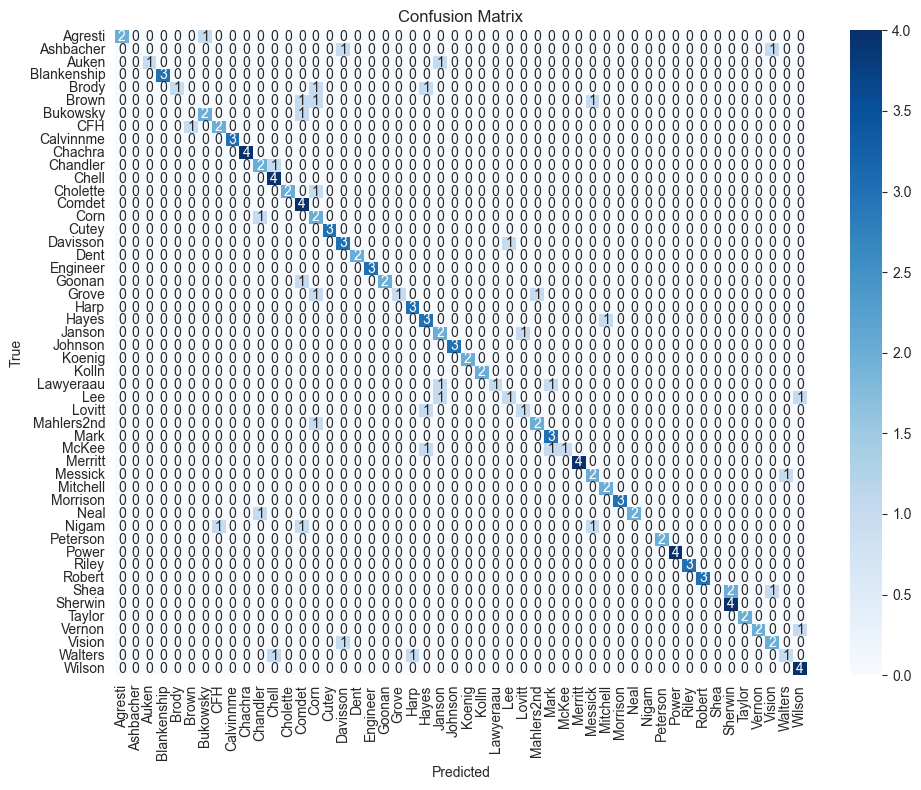

submission saved as 'reviews_submission_v17.csv'


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load and prepare the data
# -------------------------------
train_df = pd.read_csv("all_datasets/amazon_review_ID.shuf.lrn.csv")
test_df = pd.read_csv("all_datasets/amazon_review_ID.shuf.tes.csv")

X_raw = train_df.drop(columns=["ID", "Class"])
y_raw = train_df["Class"]
X_test_raw = test_df.drop(columns=["ID"])
test_ids = test_df["ID"]

# -------------------------------
# 2. Encode class labels
# -------------------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

# -------------------------------
# 3. TF-IDF Transformation
# -------------------------------
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X_raw)
X_test = tfidf.transform(X_test_raw)

# -------------------------------
# 4. Log-Count Ratio Weighting
# -------------------------------
alpha = 1
X_counts = X_raw.values
log_count_ratios = np.zeros(X_counts.shape[1])
n_classes = len(np.unique(y_encoded))

for i in range(n_classes):
    p = X_counts[y_encoded == i].sum(axis=0) + alpha
    q = X_counts[y_encoded != i].sum(axis=0) + alpha
    log_count_ratios += np.log(p / p.sum()) - np.log(q / q.sum())
log_count_ratios /= n_classes

X = X.multiply(log_count_ratios)
X_test = X_test.multiply(log_count_ratios)

# -------------------------------
# 5. Train/Validation Split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# -------------------------------
# 6. Build the Pipeline
# -------------------------------
pipeline = Pipeline([
    ("scale", StandardScaler(with_mean=False)),                     # Normalize TF-IDF values
    ("select", SelectKBest(k=5000)),                          # Filter most relevant 7k features
    ("svd", TruncatedSVD(n_components=750, random_state=42)),       # Reduce to 750 latent dimensions
    ("clf", LinearSVC(class_weight='balanced', max_iter=15000, dual=False, random_state=42))
])

# -------------------------------
# 7. Hyperparameter Grid Search
# -------------------------------
param_grid = {
    "clf__C": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1_macro",       # Macro F1 to account for any class imbalance
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# -------------------------------
# 8. Evaluation
# -------------------------------
print("\nBest Parameters:", grid.best_params_)
val_preds = grid.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, val_preds, target_names=class_names))

# Confusion Matrix
conf = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Predict on Test Set
# -------------------------------
final_model = grid.best_estimator_
test_preds = final_model.predict(X_test)
test_labels = label_encoder.inverse_transform(test_preds)

# -------------------------------
# 10. Save Kaggle Submission File
# -------------------------------
submission = pd.DataFrame({
    "ID": test_ids,
    "Class": test_labels
})
submission.to_csv("reviews_submission_17.csv", index=False)
print("submission saved as 'reviews_submission_v17.csv'")